In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wg

In [10]:
def Gaussian(x, m, s):
    """Calculates a Gaussian for an array of positions.

    Args:
        x (array): positions.
        m (float): mean.
        s (float): standard deviation.

    Returns:
        (array): Gaussian values at x."""

    G = 1 / np.sqrt(s * np.sqrt(2 * np.pi)) * np.exp(-((x - m) ** 2) / (4 * s**2))

    return G


def Exponential(x, gamma):
    """Calculates an Exponential enveloppe for an array of positions.

    Args:
        x (array): positions.
        gamma (float): exponential parameter.

    Returns:
        (array): Exponential values at x."""

    E = (gamma) ** (1 / 2) * np.exp(-gamma * x / 2) * np.heaviside(x, 1)

    return E


def Overlap(u, v, x):
    """Calculates the overlap integral between 2 wave functions.

    Args:
        u (array): wave function 1.
        v (array): wave function 2..
        x (array): positions.

    Returns:
        (float): Overlap integral value."""

    OverLap = sc.integrate.simps(np.conj(u) * v, x)

    return OverLap

### Initializing nonorthogonal functions
In this simulation, the wave enveloppes could be either Gaussian or exponential :

$$\psi(x) = \frac{1}{\sqrt{\sigma\sqrt{2\pi}}}\exp{\left(-\frac{x^2}{4\sigma^2}\right)} \hspace{12pt} \textrm{or} \hspace{12pt} \psi(x) = \sqrt{\gamma}\exp{\left(-\frac{\gamma}{2}x\right)}u(x)$$

Let $\psi_i$ be a wave function with a shift $x_i$, which means : $\psi_i(x)=\psi(x-x_i)$



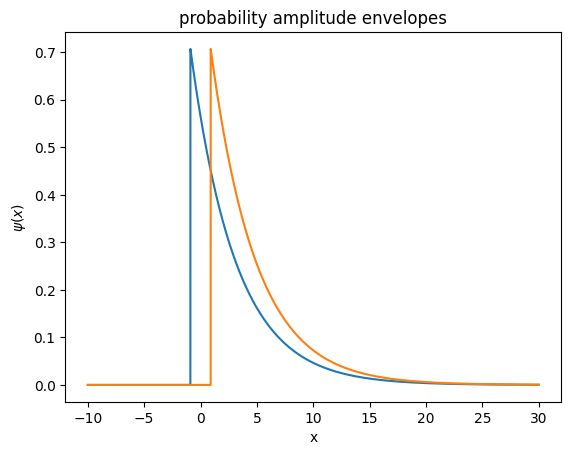

In [11]:
env_type = 2  # 1=Gaussian, 2=exponential
N = 10000  # number of x points to plot the wave functions
N_shift = 2  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

if env_type == 1:
    sigma_wave = 0.5  # standard deviation of wave function
    x = np.linspace(-8 * sigma_wave, 8 * sigma_wave, N)  # position values
    param_shift = (
        sigma_wave
    )  # standard deviation of shift values (we assume that the shift is normally distributed)
    #x_shift = np.random.uniform(-param_shift,param_shift,N_shift)  # shift values
    #x_shift = np.linspace(-2*sigma_wave,2*sigma_wave,N_shift)
    x_shift=np.array([-0.1,0.1])
    for i in range(N_shift):
        waves[i] = Gaussian(x, x_shift[i], sigma_wave)
if env_type == 2:
    gamma_wave = 0.5
    param = gamma_wave
    x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
    param_shift = 5 / (gamma_wave) / 10
    #x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values
    x_shift=np.array([-0.9,0.9])

    for i in range(N_shift):
        waves[i] = Exponential(x - x_shift[i], gamma_wave)
# plotting wave functions
plt.figure()
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.show()

### Building orthogonal base
the Gram-Schmidt Orthogonalization method consists in bulding the new orthonormal basis $\{|\theta_n\rangle\}$ from the existing wave functions $\{|\psi_i\rangle\}$ using the following method :
$$\begin{align*}
&|\theta_1\rangle=|\psi_1\rangle\\
&|\theta_2\rangle=\frac{|\psi_2\rangle-\langle\psi_2|\theta_1\rangle|\theta_1\rangle}{\langle\theta_2|\theta_2\rangle}\\
&|\theta_3\rangle=\frac{|\psi_3\rangle-\langle\psi_3|\theta_1\rangle|\theta_1\rangle-\langle\psi_3|\theta_2\rangle|\theta_2\rangle}{\langle\theta_3|\theta_3\rangle}\\
&\vdots\\
&|\theta_n\rangle=\frac{|\psi_n\rangle-\sum_i^n\langle\psi_n|\theta_i\rangle|\theta_i\rangle}{\langle\theta_n|\theta_n\rangle}
\end{align*}$$

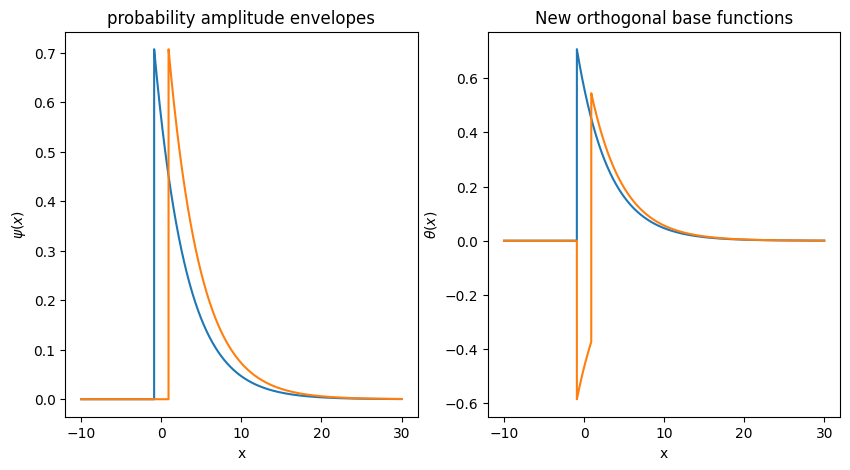

g_0 = |f_0>
g_1 = 0.6377*|f_0> + 0.7705*|f_1>


In [12]:
new_base = np.zeros((N_shift, N))
for i in range(N_shift):
    new_base[i] = waves[i]
    for j in range(i):
        new_base[i] = new_base[i] - Overlap(new_base[j], waves[i], x) * new_base[j]
    new_base[i] = new_base[i] / np.sqrt(Overlap(new_base[i], new_base[i], x))

# Plotting new wave functions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.subplot(1, 2, 2)
plt.plot(x, new_base.T)
plt.xlabel("x")
plt.ylabel(r"$\theta(x)$")
plt.title("New orthogonal base functions")
plt.savefig('schmidt.png')
plt.show()

coeffs=np.zeros((N_shift,N_shift))
for i in range(N_shift):
    for j in range(i+1):
        coeffs[i,j]=Overlap(waves[i], new_base[j], x)

for i in range(N_shift):
    strg=f'g_{i} = '
    for j in range(i+1):
        if i==0:
            strg=strg+f'|f_{j}>'
        else:
            if j==0:
                strg=strg+f'{round(coeffs[i,j],4)}*|f_{j}>'
            else:
                strg=strg+f' + {round(coeffs[i,j],4)}*|f_{j}>'

    print(strg)
        

In [13]:
for i in range(N_shift):
    for j in range(i):
        over = sc.integrate.simps(new_base[i] * new_base[j], x)
        print(f"overlap between wave function {i} and wave function {j} : {over}")
    over = sc.integrate.simps(new_base[i] * new_base[i], x)
    print(f"overlap between wave function {i} and wave function {i} : {over}")

overlap between wave function 0 and wave function 0 : 1.0000000000000002
overlap between wave function 1 and wave function 0 : -2.4363926799403744e-16
overlap between wave function 1 and wave function 1 : 1.0000000000000002


In [14]:
plt.plot(x,new_base[8].T)
plt.plot(x,-new_base[9].T)

IndexError: index 8 is out of bounds for axis 0 with size 2

In [ ]:
env_type = 1  # 1=Gaussian, 2=exponential
N = 10000  # number of x points to plot the wave functions
N_shift = 3  # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

if env_type == 1:
    sigma_wave = 0.5  # standard deviation of wave function
    x = np.linspace(-16 * sigma_wave, 16 * sigma_wave, N)  # position values
    param_shift = (
        sigma_wave
    )  # standard deviation of shift values (we assume that the shift is normally distributed)
    epsilon=1e-14
    x_shift = np.array([0,sigma_wave/2,sigma_wave/2+epsilon])  # shift values
    for i in range(N_shift):
        waves[i] = Gaussian(x, x_shift[i], sigma_wave)
if env_type == 2:
    gamma_wave = 0.5
    param = gamma_wave
    x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
    param_shift = 5 / (gamma_wave) / 10
    x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

    for i in range(N_shift):
        waves[i] = Exponential(x - x_shift[i], gamma_wave)

new_base = np.zeros((N_shift, N))
for i in range(N_shift):
    new_base[i] = waves[i]
    for j in range(i):
        new_base[i] = new_base[i] - Overlap(new_base[j], waves[i], x) * new_base[j]
    new_base[i] = new_base[i] / np.sqrt(Overlap(new_base[i], new_base[i], x))

# Plotting new wave functions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.subplot(1, 2, 2)
plt.plot(x, new_base.T)
plt.xlabel("x")
plt.ylabel(r"$\theta(x)$")
plt.title("New orthogonal base functions")
plt.savefig('schmidt.png')
plt.show()

for i in range(N_shift):
    for j in range(i):
        over = sc.integrate.simps(new_base[i] * new_base[j], x)
        print(f"overlap between wave function {i} and wave function {j} : {over}")
    over = sc.integrate.simps(new_base[i] * new_base[i], x)
    print(f"overlap between wave function {i} and wave function {i} : {over}")

NameError: name 'np' is not defined

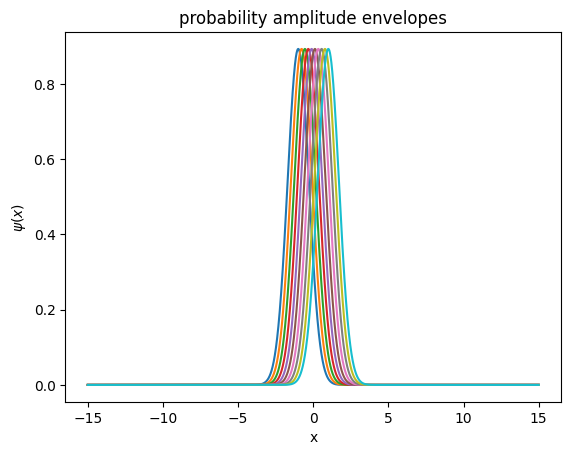

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.75610980e-01 2.19506755e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.05955191e-01 4.17987811e-01 6.73155354e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.00737403e-01 5.68305921e-01 1.87680675e-01 2.49791112e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.73638455e-01 6.53867482e-01 3.32171434e-01 9.06578457e-02
  1.05754958e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.39407507e-01 6.71444341e-01 4.66501841e-01 1.95853637e-01
  4.68503321e-02 4.94670770e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.11112291e-01 6.30148455e-01 5.61456847e-01 3.22378050e

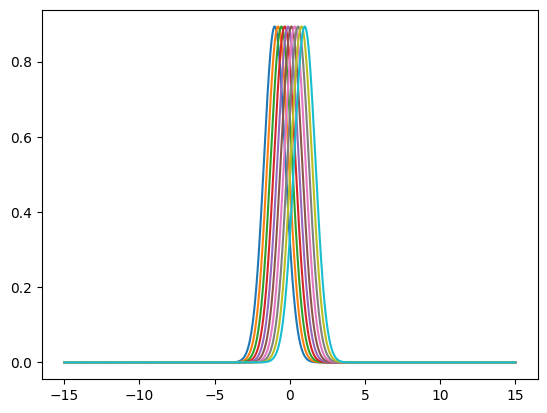

In [18]:
env_type = 1  # 1=Gaussian, 2=exponential
N = 100000  # number of x points to plot the wave functions
N_shift = 10 # total number of shifted wave functions
waves = np.zeros((N_shift, N))  # values for each wave function

if env_type == 1:
    sigma_wave = 0.5  # standard deviation of wave function
    x = np.linspace(-30 * sigma_wave, 30 * sigma_wave, N)  # position values
    param_shift = (
        sigma_wave / 10
    )  # standard deviation of shift values (we assume that the shift is normally distributed)
    x_shift = np.linspace(-2*sigma_wave,2*sigma_wave,N_shift) # shift values

    for i in range(N_shift):
        waves[i] = Gaussian(x, x_shift[i], sigma_wave)
if env_type == 2:
    gamma_wave = 0.5
    param = gamma_wave
    x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
    param_shift = 5 / (gamma_wave) / 10
    x_shift = np.linspace(-3*sigma_wave,3*sigma_wave,N_shift) # shift values

    for i in range(N_shift):
        waves[i] = Exponential(x - x_shift[i], gamma_wave)
# plotting wave functions
plt.figure()
plt.plot(x, waves.T)
plt.xlabel("x")
plt.ylabel(r"$\psi (x)$")
plt.title("probability amplitude envelopes")
plt.show()

new_base = np.zeros((N_shift, N))
for i in range(N_shift):
    new_base[i] = waves[i]
    for j in range(i):
        new_base[i] = new_base[i] - Overlap(new_base[j], waves[i], x) * new_base[j]
    new_base[i] = new_base[i] / np.sqrt(Overlap(new_base[i], new_base[i], x))


coeffs=np.zeros((N_shift,N_shift))
for i in range(N_shift):
    for j in range(i+1):
        coeffs[i,j]=sc.integrate.simps(waves[i] * new_base[j], x)

print(coeffs)
waves_new=np.zeros((N_shift,N))
for i in range(N_shift):
    for j in range(N_shift):
        waves_new[i]=waves_new[i]+coeffs[i,j]*new_base[j]
plt.plot(x, waves_new.T)

### Checking Orthogonality and normalization

In [19]:
Matrice = []
for i in range(N_shift):
    for j in range(i):
        over = sc.integrate.simps(new_base[i] * new_base[j], x)
        Matrice.append(f"overlap between wave function {i} and wave function {j} : {over}")
        print(f"overlap between wave function {i} and wave function {j} : {over}")
        
    over = sc.integrate.simps(new_base[i] * new_base[i], x)
    Matrice.append(f"overlap between wave function {i} and wave function {i} : {over}")
    print(f"overlap between wave function {i} and wave function {i} : {over}")

overlap between wave function 0 and wave function 0 : 1.0000000000000002
overlap between wave function 1 and wave function 0 : -9.992007221623849e-16
overlap between wave function 1 and wave function 1 : 1.0
overlap between wave function 2 and wave function 0 : 3.802513859349395e-15
overlap between wave function 2 and wave function 1 : 1.3489209749610143e-14
overlap between wave function 2 and wave function 2 : 0.9999999999999998
overlap between wave function 3 and wave function 0 : -1.4568207751057996e-14
overlap between wave function 3 and wave function 1 : -6.9250161151161e-14
overlap between wave function 3 and wave function 2 : -4.3134940032566413e-13
overlap between wave function 3 and wave function 3 : 1.0000000000000002
overlap between wave function 4 and wave function 0 : 5.312417173192373e-14
overlap between wave function 4 and wave function 1 : 2.2398749540004766e-13
overlap between wave function 4 and wave function 2 : 2.621104728020745e-12
overlap between wave function 4 a

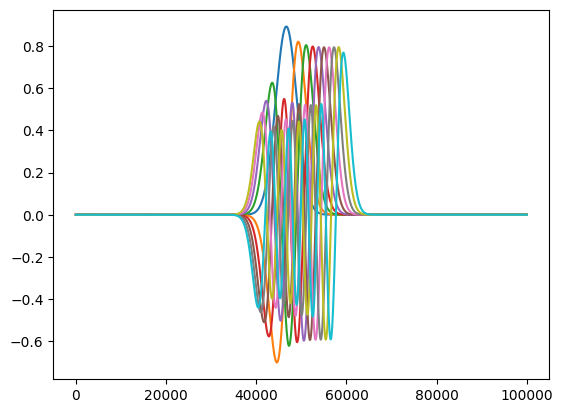

In [20]:
plt.plot(new_base.T)

### Interactive presentation

In [ ]:
def schmidt(N_shift):
    N_shift=int(N_shift)
    env_type = 2  # 1=Gaussian, 2=exponential
    N = 500  # number of x points to plot the wave functions
    waves = np.zeros((N_shift, N))  # values for each wave function

    if env_type == 1:
        sigma_wave = 0.5  # standard deviation of wave function
        x = np.linspace(-8 * sigma_wave, 8 * sigma_wave, N)  # position values
        param_shift = (
            sigma_wave / 10
        )  # standard deviation of shift values (we assume that the shift is normally distributed)
        x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values
        for i in range(N_shift):
            waves[i] = Gaussian(x, x_shift[i], sigma_wave)
    if env_type == 2:
        gamma_wave = 0.5
        param = gamma_wave
        x = np.linspace(-5 / gamma_wave, 15 / gamma_wave, N)  # position values
        param_shift = 5 / (gamma_wave) / 10
        x_shift = np.random.standard_cauchy(N_shift) * param_shift  # shift values

        for i in range(N_shift):
            waves[i] = Exponential(x - x_shift[i], gamma_wave)
    new_base = np.zeros((N_shift, N))
    for i in range(N_shift):
        new_base[i] = waves[i]
        for j in range(i):
            new_base[i] = new_base[i] - Overlap(new_base[j], waves[i], x) * new_base[j]
        new_base[i] = new_base[i] / np.sqrt(Overlap(new_base[i], new_base[i], x))

    # Plotting new wave functions
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, waves.T)
    plt.xlabel("x")
    plt.ylabel(r"$\psi (x)$")
    plt.title("probability amplitude envelopes")
    plt.subplot(1, 2, 2)
    plt.plot(x, new_base.T)
    plt.xlabel("x")
    plt.ylabel(r"$\theta(x)$")
    plt.title("New orthogonal base functions")
    #plt.savefig('schmidt.png')
    plt.show()
N_shift=2
N_shift_slide = wg.FloatSlider(value=N_shift,min=2,max=10,step=1)
wg.interact(schmidt, N_shift=N_shift_slide)

interactive(children=(FloatSlider(value=2.0, description='N_shift', max=10.0, min=2.0, step=1.0), Output()), _…

<function __main__.schmidt(N_shift)>